In [3]:
#The following Notebook is my response to Kaggle's competiton: "House Prices: Advanced Regression Techniques" 
#(https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

#The goal is to generate a regression model that can predict a house's sale price based on a set of 
#features about that house. NOTE: The test set does not have a Sale Price variable, submissions are judged 
#based on predicting the unknown Test Sale Prices.

In [120]:
#LOAD AND DO INITIAL DATA CLEANING

import os
import numpy as np
import pandas as pd
from six.moves import urllib

%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

#Load both your training and test sets
train_set = pd.read_csv('C:/Users/james/Desktop/Computer Club/houseprice/train.csv')
test_set = pd.read_csv('C:/Users/james/Desktop/Computer Club/houseprice/test.csv')

#Separate out the outcome variable for the training set
Ytrain = train_set["SalePrice"]
train_set = train_set.drop("SalePrice", axis=1)

train_ID = train_set["Id"]
train_set = train_set.drop("Id", axis=1)

test_ID = test_set["Id"]
test_set = test_set.drop("Id", axis=1)



In [121]:
#Next, let's validate the normality of the test variable SalePrice
print("Skewness: %f" % Ytrain.skew())
print("Kurtosis: %f" % Ytrain.kurt())


Skewness: 1.882876
Kurtosis: 6.536282


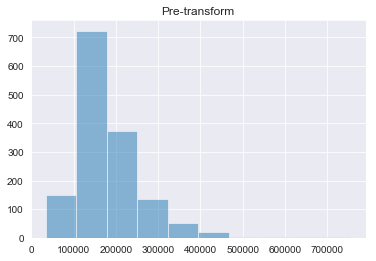

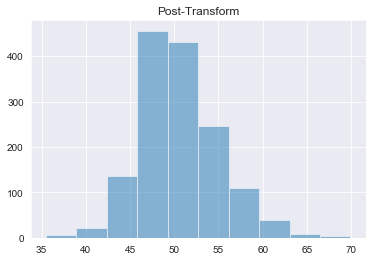

In [122]:
#There's a little skew to SalePrice, so we'll use a Box-Cox transform
from matplotlib import pyplot
from scipy.special import boxcox1p

Ytrain2 = boxcox1p(Ytrain,.2)

pyplot.hist(Ytrain, alpha=0.5, label='Pre-transform')
pyplot.title('Pre-transform')
pyplot.show()

pyplot.hist(Ytrain2, alpha=0.5, label='Post-trainsform')
pyplot.title('Post-Transform')
pyplot.show()



In [123]:
#Finally, before we clean data, let's just get a sense of the most correlated features to SalePrice
from scipy.stats import linregress
#linregress(a, b)
#corr_matrix = Ytrain.corr(train_set)
#corr_matrix.sort_values(ascending=False)

allrs = np.empty([train_set.select_dtypes(exclude=['object']).shape[1],1]) # the default dtype is float, so set dtype if it isn't float
#m, b, r_value, p_value, stderr  = linregress(Ytrain,train_set.select_dtypes(exclude=['object']).iloc[:,3])
#print(r_value)

for x in range(train_set.select_dtypes(exclude=['object']).shape[1]):
    m, b, r_value, p_value, stderr  = linregress(Ytrain,train_set.select_dtypes(exclude=['object']).iloc[:,x])
    allrs[x]=r_value

dispArray = pd.DataFrame({'Variables' : train_set.select_dtypes(exclude=['object']).columns.values, 'Rsq' : allrs[:,0]})
dispArray.sort_values(by=['Rsq'],ascending=False)

,Variables,Rsq
3,OverallQual,0.790982
15,GrLivArea,0.708624
25,GarageCars,0.640409
26,GarageArea,0.623431
11,TotalBsmtSF,0.613581
12,1stFlrSF,0.605852
18,FullBath,0.560664
22,TotRmsAbvGrd,0.533723
5,YearBuilt,0.522897
6,YearRemodAdd,0.507101


In [124]:
#Interesting! As it should, overall quality is the best predictor of sale price.
#Let's move on and clean the data

#First, recombine training and test sets to streamline this clean-up
allsetlist = [train_set, test_set]
allset = pd.concat(allsetlist)
trainlen = len(train_set)

#Remove columns with too much missing data
def missing_values(df, percentage):

    columns = df.columns
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

    missing_drop = list(missing_value_df[missing_value_df.percent_missing>percentage].column_name)
    df = df.drop(missing_drop, axis=1)
    return missing_drop, df

missing_drop, allset = missing_values(allset,20) #We set our missing data threshold to 20

#Drop columns with subjective responses
#drops = ['MSSubClass','Condition1','Condition2','OverallQual',
#             'OverallCond','ExterQual','ExterCond','BsmtCond','LowQualFinSF',
#             'KitchenQual','GarageQual','SaleType','MiscVal','Functional','SaleCondition']

#allset = allset.drop(drops, axis=1)


#Place dummy variables in categoricals

allset = pd.get_dummies(allset)

#Split combined dataframe back to training and test set

train_set = allset.iloc[0:trainlen]
test_set = allset.iloc[trainlen:]


In [125]:
#Fill in missing data, normalize data, and then run linear regression analysis


import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error


fullpipe = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])


trainprepped = fullpipe.fit_transform(train_set)


lin_reg = LinearRegression()
lin_reg.fit(trainprepped, Ytrain)


housing_predictions = lin_reg.predict(trainprepped)
lin_mse = mean_squared_log_error(Ytrain, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
display(lin_rmse)






C:\Users\james\Anaconda3\envs\mlbook\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


0.11126564743609503

In [126]:
#Great! So our rmse is pretty good at .11. Let's see if we can do better with a random forest model with CV sweep

#RANDOM FOREST WITH CV SEARCH 

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_log_error')

grid_search.fit(trainprepped, Ytrain)

display(grid_search.best_params_)
display(grid_search.best_estimator_)

cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)



{'max_features': 8, 'n_estimators': 30}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

0.22785660368168956 {'max_features': 2, 'n_estimators': 3}
0.19487615984036424 {'max_features': 2, 'n_estimators': 10}
0.18299831905639607 {'max_features': 2, 'n_estimators': 30}
0.2254474044059088 {'max_features': 4, 'n_estimators': 3}
0.18844012502741841 {'max_features': 4, 'n_estimators': 10}
0.1730448377570158 {'max_features': 4, 'n_estimators': 30}
0.21265382294707527 {'max_features': 6, 'n_estimators': 3}
0.18579183537759494 {'max_features': 6, 'n_estimators': 10}
0.165300995848224 {'max_features': 6, 'n_estimators': 30}
0.20239128680456414 {'max_features': 8, 'n_estimators': 3}
0.17097830151211768 {'max_features': 8, 'n_estimators': 10}
0.1623729037856545 {'max_features': 8, 'n_estimators': 30}
0.22918262475044435 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.1862797220093345 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.22153778822595604 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.1812817177244498 {'bootstrap': False, 'max_feature

In [129]:
#Interesting. Within that parameter space, we don't get anything better with the random forest.
#let's go ahead and run the linear regression with the test set, and export our findings for evaluation

testprepped = fullpipe.fit_transform(test_set)
test_housing_predictions = lin_reg.predict(testprepped)


finArray = pd.DataFrame({'Id' : test_ID, 'Predicted_SalePrice' : test_housing_predictions})
finArray.to_csv('SalePricePredict.csv',index=False)
